In [1]:
!pip install scikit-learn
!pip install xgboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement sckit-learn (from versions: none)
ERROR: No matching distribution found for sckit-learn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [3]:
data = pd.read_csv('/content/StudentsPerformance.csv')

In [4]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [9]:
columns_renamed = {
    "race/ethnicity":"race",
     "parental level of education":"parental_level_of_education",
     "test preparation course":"prep_course",
     "math score":"math_score",
     "writing score":"writing_score",
     "reading score": "reading_score",
     
}
data.rename(columns = columns_renamed, inplace = True)

In [10]:
X = data.drop(columns=['math_score'],axis=1)

In [11]:
X

,gender,race,parental_level_of_education,lunch,prep_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [14]:
print("Categories in 'gender' variable:     ",end=" " )
print(data['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(data['race'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(data['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(data['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(data['prep_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [16]:
y = data['math_score']

In [17]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

## **Transform Columns**

In [18]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [19]:
X = preprocessor.fit_transform(X)

In [20]:
X.shape

(1000, 19)

## **Splitting the Dataset**

In [21]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

## **Function for Model Evaluation**

In [22]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

## **Select Models**

In [24]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

## **Training and Testing**

In [25]:
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3231
- Mean Absolute Error: 4.2667
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3940
- Mean Absolute Error: 4.2148
- R2 Score: 0.8804


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7091
- Mean Absolute Error: 4.5175
- R2 Score: 0.8554
-----------------------

In [26]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.880593
0,Linear Regression,0.880433
8,AdaBoost Regressor,0.855112
5,Random Forest Regressor,0.852977
7,CatBoosting Regressor,0.851632
1,Lasso,0.825320
6,XGBRegressor,0.821589
3,K-Neighbors Regressor,0.783497
4,Decision Tree,0.749875


## **Linear Regression**

In [31]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 88.04


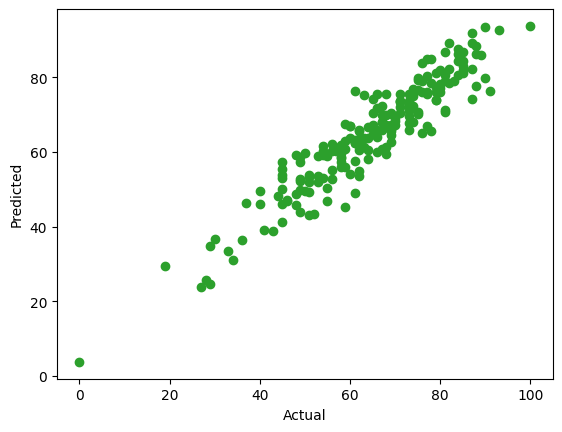

In [32]:
plt.scatter(y_test,y_pred,c=['#2ca02c']);
plt.xlabel('Actual');
plt.ylabel('Predicted');

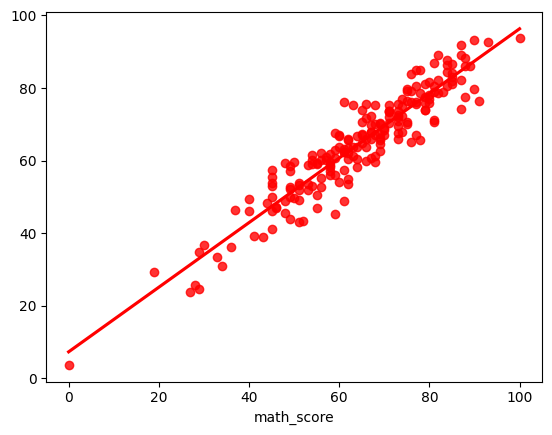

In [33]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

## **Difference: Predictions vs Actual Values**

In [34]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.387970,14.612030
737,53,58.885970,-5.885970
740,80,76.990265,3.009735
660,74,76.851804,-2.851804
411,84,87.627378,-3.627378
...,...,...,...
408,52,43.409149,8.590851
332,62,62.152214,-0.152214
208,74,67.888395,6.111605
613,65,67.022287,-2.022287
